In [11]:
#Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
#Load in NYSE data
data = pd.read_csv('/kaggle/input/nyse/prices-split-adjusted.csv', parse_dates = True)
data.tail()

,date,symbol,open,close,low,high,volume
851259,2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0
851260,2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0
851261,2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0
851262,2016-12-30,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0
851263,2016-12-30,FTV,54.200001,53.630001,53.389999,54.480000,705100.0


In [13]:
#Pick two stocks for 2016: ZBH (Zimmer Biomet) & WLTW (Willis Towers Watson)
WLTW = data.loc[(data.symbol == 'WLTW') & (data.date >= '2016-01-05') & (data.date <= '2016-12-31')]
ZBH = data.loc[(data.symbol == 'ZBH') & (data.date >= '2016-01-05') & (data.date <= '2016-12-31')]

WLTW.reset_index(inplace = True)
ZBH.reset_index(inplace = True)

WLTW = WLTW.drop('index', axis = 1)
ZBH = ZBH.drop('index', axis = 1)

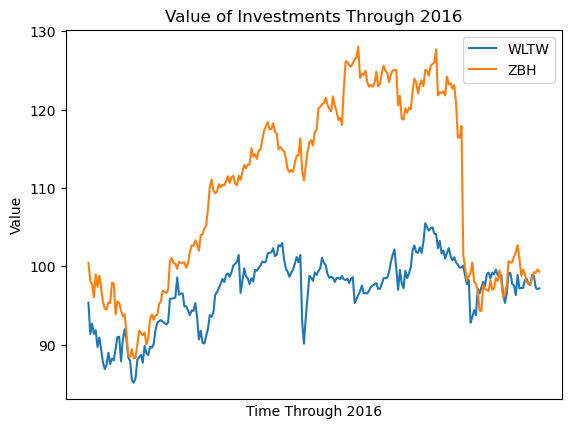

In [14]:
#Invest $100 in each stock on Jan 5th and hold until Dec 30th - how do they move (close price)?
WLTW['daily_close_return'] = WLTW.close.pct_change()
ZBH['daily_close_return'] = ZBH.close.pct_change()

WLTW.dropna(inplace = True)
ZBH.dropna(inplace = True)

WLTW['returns_100'] = 100 * np.cumprod(WLTW.daily_close_return + 1)
ZBH['returns_100'] = 100 * np.cumprod(ZBH.daily_close_return + 1)

plt.plot(WLTW.date, WLTW.returns_100)
plt.plot(ZBH.date, ZBH.returns_100)
plt.legend(['WLTW', 'ZBH'])
plt.xticks([])
plt.title('Value of Investments Through 2016')
plt.xlabel('Time Through 2016')
plt.ylabel('Value')
plt.show()

In [15]:
#Mean and standard deviation of both
print(('Mean of WLTW: ' + str(round((WLTW.returns_100.values[-1] - 100) / 100, 2))))
print('Standard Deviation of WLTW: ' + str(round(np.std(WLTW.daily_close_return) * np.sqrt(len(WLTW.daily_close_return)), 2)))

print(('Mean of ZBH: ' + str(round((ZBH.returns_100.values[-1] - 100) / 100, 2))))
print('Standard Deviation of ZBH: ' + str(round(np.std(ZBH.daily_close_return) * np.sqrt(len(ZBH.daily_close_return)), 2)))

Mean of WLTW: -0.03
Standard Deviation of WLTW: 0.23
Mean of ZBH: -0.01
Standard Deviation of ZBH: 0.24


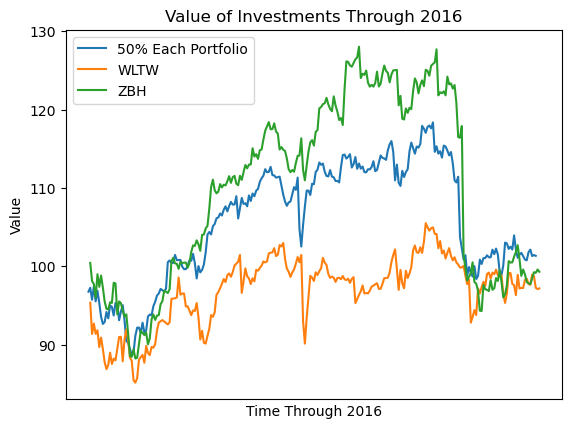

In [16]:
#50% weighting to each stock
df_WLTW_ZBH = pd.concat([WLTW[['date', 'close']], ZBH.close], axis = 1)
df_WLTW_ZBH.columns = ['date', 'WLTW', 'ZBH']
df_WLTW_ZBH.WLTW = df_WLTW_ZBH.WLTW.pct_change()
df_WLTW_ZBH.ZBH = df_WLTW_ZBH.ZBH.pct_change()
df_WLTW_ZBH = df_WLTW_ZBH.dropna()
df_WLTW_ZBH['port_return'] = 0.5 * df_WLTW_ZBH.WLTW + 0.5 * df_WLTW_ZBH.ZBH
df_WLTW_ZBH['port_return_100'] = 100 * np.cumprod(df_WLTW_ZBH.port_return + 1)
plt.plot(df_WLTW_ZBH.date, df_WLTW_ZBH.port_return_100)
plt.plot(WLTW.returns_100)
plt.plot(ZBH.returns_100)
plt.legend(['50% Each Portfolio', 'WLTW', 'ZBH'])
plt.xticks([])
plt.title('Value of Investments Through 2016')
plt.xlabel('Time Through 2016')
plt.ylabel('Value')
plt.show()

In [17]:
#By diversifying, not only did we have a positive return, but we also had lower risk than both stocks
print(('Mean of Portfolio: ' + str(round((df_WLTW_ZBH.port_return_100.values[-1] - 100) / 100, 2))))
print('Standard Deviation of Portfolio: ' + str(round(np.std(df_WLTW_ZBH.port_return) * np.sqrt(len(df_WLTW_ZBH.port_return)), 2)))

Mean of Portfolio: 0.01
Standard Deviation of Portfolio: 0.19


In [ ]:
#Install PyPortfolioOpt
! pip install PyPortfolioOpt

In [ ]:
#Generate efficient frontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import sample_cov
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import plotting

df_WLTW_ZBH = pd.concat([WLTW[['close']], ZBH.close], axis = 1)
df_WLTW_ZBH.columns = ['WLTW', 'ZBH']
mu = mean_historical_return(df_WLTW_ZBH)
S = sample_cov(df_WLTW_ZBH)

ef = EfficientFrontier(mu, S)
plotting.plot_efficient_frontier(ef)
plt.title('Efficient Frontier for Two Stock Portfolio')
plt.show()

In [ ]:
#Pick 50 different stocks
np.random.seed(777)

stocks_random = np.random.choice(data.loc[(data.date >= '2016-01-05') & (data.date <= '2016-12-31')].symbol.unique(), 50)

stocks_50 = data.loc[data.symbol.isin(stocks_random)]

stocks_50_wide = stocks_50[['date', 'symbol', 'close']].pivot_table(index = 'date',
                                           columns = 'symbol',
                                           values = 'close')

stocks_50_wide = stocks_50_wide.loc[(stocks_50_wide.index >= '2016-01-05') & (stocks_50_wide.index <= '2016-12-31')]

mu = mean_historical_return(stocks_50_wide)
S = sample_cov(stocks_50_wide)

ef = EfficientFrontier(mu, S)
plotting.plot_efficient_frontier(ef)
plt.title('Efficient Frontier for 100 Stock Portfolio')
plt.show()

In [ ]:
#Pretty it up for full clarification from pyportfolioopt package documentation
mu = mean_historical_return(stocks_50_wide)
S = sample_cov(stocks_50_wide)

ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets = False)

# Find the tangency portfolio
ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt(np.diag(w @ S @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with Max Sharpe Portfolio")
plt.xlim([0.09, 0.25])
ax.legend()
plt.tight_layout()
plt.show()